# Setup

In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
from config import *
from path import get_eval_prs_root_path, GTS_PATH
from data import describe_da, compute_results_da_class_splitted

import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
import xarray as xr

# Assessment

In [23]:
exp_name = "temps"

In [24]:
exp_path = get_eval_prs_root_path("LRASPP_MobileNet_V3", "class-splitted") / "gemma3:12b-it-qat" / exp_name
exp_path

PosixPath('/home/olivieri/exp/data/prompts_data/by_model/LRASPP_MobileNet_V3/class-splitted/eval_prs/gemma3:12b-it-qat/temps')

In [25]:
var_names = [os.path.splitext(os.path.basename(path))[0] for path in glob(f"{exp_path}/*.jsonl")]
var_names

['temp_1.0', 'temp_0.7', 'temp_0.5', 'temp_0.3']

In [26]:
data_da = compute_results_da_class_splitted(exp_path, 21)

## Pred

In [27]:
display(describe_da(data_da.sel(metric="pred").mean("pos_class"), dims_to_agg=["img_idx"]))
display(describe_da(data_da.sel(metric="pred").mean("pos_class").mean("img_idx"), dims_to_agg=["var"]))

stat,mean,std,min,max
var,,,,
temp_0.3,0.672152,0.409370,0.0,1.0
temp_0.5,0.658439,0.385925,0.0,1.0
temp_0.7,0.676371,0.388305,0.0,1.0
temp_1.0,0.620042,0.418427,0.0,1.0


stat
mean    0.656751
std     0.025642
min     0.620042
max     0.676371
dtype: float64

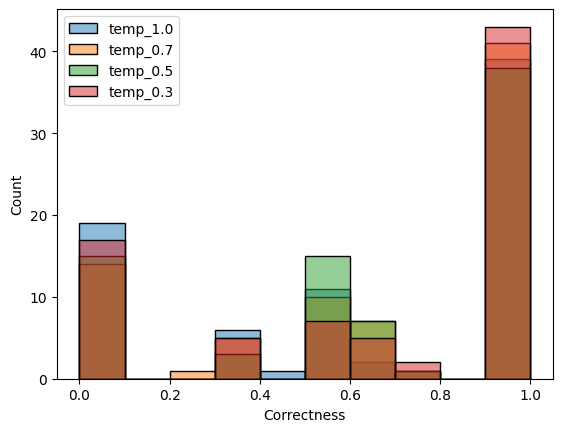

In [28]:
[sns.histplot(data_da.sel(metric="pred").mean("pos_class").loc[var_n], bins=10, alpha=0.5, label=var_n)
 for var_n in var_names]
plt.xlabel('Correctness')
plt.ylabel('Count')
plt.legend()

## Score

In [29]:
display(describe_da(data_da.sel(metric="score").mean("pos_class"), dims_to_agg=["img_idx"]))
display(describe_da(data_da.sel(metric="score").mean("pos_class").mean("img_idx"), dims_to_agg=["var"]))

stat,mean,std,min,max
var,,,,
temp_0.3,3.402321,1.275921,0.666667,5.0
temp_0.5,3.330169,1.141396,0.666667,5.0
temp_0.7,3.421308,1.236664,0.333333,5.0
temp_1.0,3.172363,1.303663,0.500000,5.0


stat
mean    3.331540
std     0.113148
min     3.172363
max     3.421308
dtype: float64

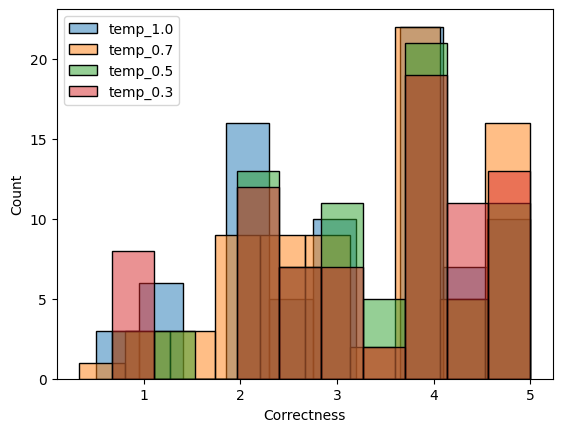

In [30]:
[sns.histplot(data_da.sel(metric="score").mean("pos_class").loc[var_n], bins=10, alpha=0.5, label=var_n)
 for var_n in var_names]
plt.xlabel('Correctness')
plt.ylabel('Count')
plt.legend()

## Per-Class

In [31]:
display(describe_da(data_da.sel(metric="pred").mean("img_idx"), dims_to_agg=["var"]))

/home/olivieri/.local/lib/python3.11/site-packages/xarray/computation/nanops.py:118: RuntimeWarning: invalid value encountered in divide
  data = data / (valid_count - ddof)
/opt/conda/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


stat,mean,std,min,max
pos_class,,,,
0,NaN,NaN,NaN,NaN
1,0.833333,0.192450,0.666667,1.000000
2,0.583333,0.166667,0.333333,0.666667
3,0.375000,0.478714,0.000000,1.000000
4,0.666667,0.136083,0.500000,0.833333
5,0.750000,0.215166,0.500000,1.000000
6,0.833333,0.192450,0.666667,1.000000
7,0.625000,0.250000,0.500000,1.000000
8,0.638889,0.139812,0.444444,0.777778


In [32]:
shape = len(data_da.coords["img_idx"]), len(data_da.coords["pos_class"])
table = xr.DataArray(np.empty(shape, dtype=object), coords=[data_da.coords["img_idx"], data_da.coords["pos_class"]]) # shape (n_imgs, n_pos_classes)

for img_idx in table.coords["img_idx"].values:
    significant_classes_gt = get_significant_classes(GTS_PATH / (image_UIDs[img_idx] + ".png"), 224, CLASS_MAP)
    for c in significant_classes_gt:
        if table.loc[img_idx, c] == None:
            table.loc[img_idx, c] = 1
class_counts = table.sum("img_idx")

NameError: name 'get_significant_classes' is not defined

/opt/conda/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


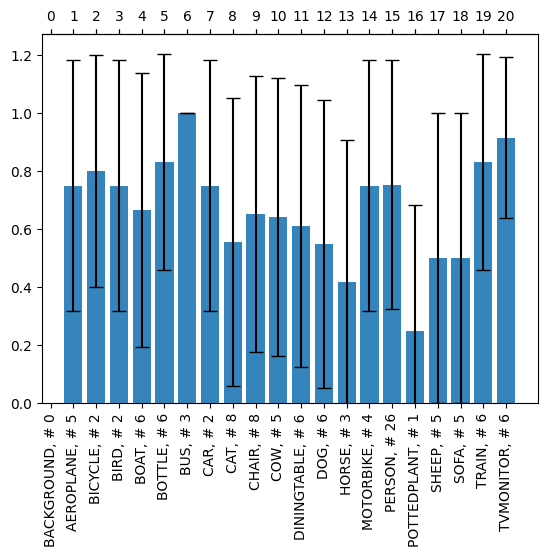

In [ ]:
mean = data_da.sel(metric="pred").astype(float).mean(["img_idx", "var"])
std = data_da.sel(metric="pred").astype(float).std(["img_idx", "var"])
plt.bar([f"{CLASSES[i]}, # {int(class_counts[i])}" for i in mean.coords["pos_class"].values], mean, yerr=std, capsize=5, alpha=0.9)
plt.tick_params(axis='x', which='both', top=True)
top_ax = plt.gca().secondary_xaxis('top')
top_ax.set_xticks(range(len(mean.coords["pos_class"])))
top_ax.set_xticklabels(mean.coords["pos_class"].values)
plt.ylim(bottom=0)
plt.xticks(rotation=90)
plt.show()